In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_56545/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
# unused for this file
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
import sys
import importlib
sys.path.append("../../solutions/utils/")
import circuit_utils, zne_utils, tomography_utils
importlib.reload(circuit_utils)
importlib.reload(zne_utils) # unused for this file
importlib.reload(tomography_utils) # unused for this file
from circuit_utils import *
from zne_utils import zne_wrapper, zne_decoder
from tomography_utils import expvals_to_valid_rho

In [7]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

In [8]:
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
print("trotter step list: ", num_steps_list)

scale_factors = [1.0, 2.0, 3.0] # unused for this file

shots = 1 << 13
reps = 8 # unused

target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

trotter step list:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [9]:
# QREM
qr = QuantumRegister(num_qubits, name="calq")
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# we have to feed initial_layout to calibration matrix
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())

retrieved_cal_job = cal_job
cal_results = retrieved_cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

Job ID 2ca1f716-cd78-4ceb-88bf-96cbb32b34c0


In [10]:
qrem_fid_list = []
qrem_stddev_list = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, name="q")
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
    trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
    subspace_decoder_init110(qc, targets=[0, 1, 2]) # decode

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({dt: target_time / num_steps})
    print("created qc")

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
    print("created st_qcs (length:", len(st_qcs), ")")

    # remove barriers
    st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
    print("removed barriers from st_qcs")

    # optimize circuit
    t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

    # zne wrapping
    zne_qcs = t3_st_qcs
    # zne_qcs = zne_wrapper(t3_st_qcs, scale_factors = scale_factors, pt = False)
    # print("created zne_qcs (length:", len(zne_qcs), ")")

    # optimization_level must be 0
    # feed initial_layout here to see the picture of the circuits before casting the job
    t3_zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
    print("created t3_zne_qcs (length:", len(t3_zne_qcs), ")")
    
    jobs = []
    for _ in range(reps):
        #! CHECK: run t3_zne_qcs, with optimization_level = 0 and straightforward initial_layout
        job = execute(t3_zne_qcs, backend, shots=shots, optimization_level=0)
        print('Job ID', job.job_id())
        jobs.append(job)
    
    retrieved_jobs = jobs
    qrem_fids = []
    for job in retrieved_jobs:
        raw_results = job.result()
        mit_results = meas_fitter.filter.apply(raw_results)
        qrem_rho = StateTomographyFitter(mit_results, t3_zne_qcs).fit(method='lstsq')
        qrem_fids.append(state_fidelity(qrem_rho, target_state))

    qrem_fid_list.append(np.mean(qrem_fids))
    qrem_stddev_list.append(np.std(qrem_fids))
    
    t2 = time.perf_counter()
    print('qrem state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(qrem_fids), np.std(qrem_fids)))
    print("time:", t2 - t1)
    print()

trotter steps:  1
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
Job ID f662c304-7854-419a-929a-ec5b0380be3a
Job ID 185c8375-4481-405d-ab9b-cd9abab33614
Job ID b2c7ec0a-f1f6-4d67-b4b5-7de65442817a
Job ID af8f6803-90eb-4756-886e-1640073f4696
Job ID 3c878396-4adf-4f0d-8bff-5e3473dfa38b
Job ID 8f1a3d82-9956-467f-a3ac-43ed551819f5
Job ID 6bbe8413-c54c-44b0-a072-061b492a8344
Job ID 0de0f397-6b4a-4710-8470-f29a70c791a2
qrem state tomography fidelity = 0.9825 ± 0.0014
time: 24.090446446999977

trotter steps:  2
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
Job ID 6de85d0b-875b-4c05-b6c8-684c277c3890
Job ID 5e89a670-9c72-46c8-be15-67e6a0422693
Job ID 1841d89c-3585-48ce-9842-05ea8dcad194
Job ID aa65685e-eb73-4bbb-924f-cbbbbd7a4b8b
Job ID 49aba1bc-5528-467c-93cb-9f5b52dedf4b
Job ID 679c2fe0-1858-4f83-8050-ca288ad3f2de
Job I

created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
Job ID 8452fe43-541f-4453-89d6-70ebc611bb15
Job ID d384b3bb-6b91-4c1b-8a43-cdc402580631
Job ID 8a7dbaab-5383-4cc9-9627-7192f33edfbd
Job ID b63bab8d-33b9-4a4c-8ddb-fa3ec4b5b03b
Job ID d63fb100-5711-47b4-b203-50873fa28097
Job ID deb2c943-3883-4a74-99d2-b8080731d0db
Job ID 4c980c2e-85a2-46dc-8367-dcf76d146f99
Job ID 6802b47c-47e2-4e07-9d37-988ee244b295
qrem state tomography fidelity = 0.9512 ± 0.0013
time: 26.65859484299972

trotter steps:  70
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )
Job ID 5edcbb1e-592f-4df4-b8a2-bf6921d6b588
Job ID a0fc70c1-07ab-4056-a07e-811674b989d0
Job ID e27fd742-6ed3-4eec-b4eb-efc831f9f786
Job ID ad7e3162-6ddf-4a23-88f3-0f713dc9fdf8
Job ID c4b68400-2e89-4df2-a778-f0cb81c6b1bc
Job ID 38d1eef8-337e-4ad2-b31e-4f3d80e2ae1d
Job ID 3f937ebb-856c-486d-95a9-6cad499997f3
Job ID 344a4ffd-4c0f-4dfe-a092-f8e791a435c3
qrem

In [14]:
with open("e2d2_qrem.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fid": qrem_fid_list, "stddev": qrem_stddev_list}, f)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table

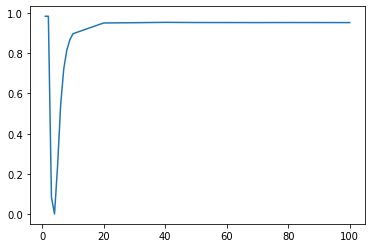

In [13]:
plt.plot(num_steps_list, qrem_fid_list)